In [73]:
##MODELO: FASE 1
import gurobipy as gp
from gurobipy import GRB
import json
import time

#Tiempo de inicio
start_time = time.time()
# Cargar datos
archivo = r"C:\Users\Salma\OneDrive - Universidad de los andes\2025-1 SALMA\METAHEURISTICAS\Proyecto\test_system_1.json"
with open(archivo, "r") as file:
    data = json.load(file)

# Procesar vehículos
vehicles = []
for v in data["arrivals"]:
    if "battery_capacity" in v:
        # Calcular required_energy como porcentaje de battery_capacity
        required_energy = v["battery_capacity"] * (v["required_energy"] / 100)
    else:
        # Usar el valor directo de required_energy
        required_energy = float(v["required_energy"])
    
    # Añadir los datos del vehículo a la lista
    vehicles.append({
        "id": v["id"],
        "arrival_time": int(v["arrival_time"] * 4),  # Convertir a intervalos de 15 minutos
        "departure_time": int(v["departure_time"] * 4),
        "required_energy": required_energy
    })

T = max(v["departure_time"] for v in vehicles)

# Procesar precios de energía
raw_energy_prices = {int(entry["time"] * 4): float(entry["price"]) for entry in data["energy_prices"]}
energy_prices = {}
last_price = 0.0
for t in range(T + 1):
    if t in raw_energy_prices:
        last_price = raw_energy_prices[t]
    energy_prices[t] = last_price

# Procesar cargadores y transformador
chargers = data["parking_config"]["chargers"]
transformer_limit = float(data["parking_config"]["transformer_limit"])

# Crear el modelo de optimización
model = gp.Model("EV_Charging")

# Índices
I = range(len(vehicles))  # Vehículos
J = range(len(chargers))  # Cargadores
T = max(v["departure_time"] for v in vehicles)  # Último intervalo

# Variables de decisión
x = model.addVars(I, J, T, vtype=GRB.BINARY, name="x")  # Asignación de cargador
E = model.addVars(I, J, T, vtype=GRB.CONTINUOUS, name="E")  # Energía entregada
E_total = model.addVars(I, vtype=GRB.CONTINUOUS, name="E_total")  # Energía total por vehículo

# Función objetivo: maximizar la energía total entregada
model.setObjective(gp.quicksum(E_total[i] for i in I), GRB.MAXIMIZE)

# Restricción: cada vehículo usa un solo cargador por intervalo
for i in I:
    for t in range(vehicles[i]["arrival_time"], vehicles[i]["departure_time"]):
        model.addConstr(gp.quicksum(x[i, j, t] for j in J) <= 1, name=f"single_charger_{i}_{t}")

# Restricción: la energía asignada depende de la asignación del cargador y su capacidad
for i in I:
    for j in J:
        for t in range(vehicles[i]["arrival_time"], vehicles[i]["departure_time"]):
            model.addConstr(E[i, j, t] <= x[i, j, t] * chargers[j]["power"], name=f"charger_capacity_{i}_{j}_{t}")

# Restricción: energía total entregada por vehículo
for i in I:
    model.addConstr(E_total[i] == gp.quicksum(E[i, j, t] for j in J for t in range(vehicles[i]["arrival_time"], vehicles[i]["departure_time"])),
                    name=f"total_energy_{i}")

# Restricción: capacidad total del transformador por intervalo
for t in range(T):
    model.addConstr(gp.quicksum(E[i, j, t] for i in I for j in J) <= transformer_limit, name=f"transformer_capacity_{t}")

# Restricción: La energía total asignada a cada vehículo no supera su requerimiento
for i in I:
    model.addConstr(E_total[i] <= vehicles[i]["required_energy"], name=f"energy_limit_{i}")

# Restricción: La energía total entregada en cada cargador no debe exceder su capacidad en cada intervalo
for j in J:
    for t in range(T):
        model.addConstr(gp.quicksum(E[i, j, t] for i in I) <= chargers[j]["power"], name=f"charger_capacity_{j}_{t}")

    
# Optimizar el modelo
model.optimize()

# Guardar la energía total asignada a cada vehículo
energy_delivered = {i: E_total[i].X for i in I}

# Calcular el costo total
total_cost = sum(
    E[i, j, t].X * energy_prices[t]
    for i in I
    for j in J
    for t in range(vehicles[i]["arrival_time"], vehicles[i]["departure_time"])
)

#Tiempo de finalización
end_time = time.time()
execution_time = end_time - start_time
# Mostrar resultados organizados por intervalo y por cargador
print("\nSolución de carga por intervalo y cargador:")
for t in range(T):
    print(f"\nIntervalo {t}:")
    for j in J:
        assigned_vehicles = [(i, E[i, j, t].X) for i in I if x[i, j, t].X > 0]
        if assigned_vehicles:
            print(f"  Cargador {j}:")
            for vh, energia in assigned_vehicles:
                print(f"    Vehículo {vh} carga {energia:.2f} kWh")
        else:
            print(f"  Cargador {j}: No asignado")

# Mostrar resultados organizados por vehículo: energía total entregada y comparación con su requerimiento
print("\nResultados finales por vehículo:")
energia_entregada_total =0  # Inicizalización Energía total entregada a los vehículos
energia_requerida_total = 0 # Inicizalización Energía requerida por los vehículos
for i in I:
    energia_entregada = E_total[i].X  # Energía total entregada al vehículo
    energia_requerida = vehicles[i]["required_energy"]  # Energía requerida por el vehículo
    print(f"Vehículo {vehicles[i]['id']}:")
    print(f"  Energía entregada: {energia_entregada:.2f} kWh")
    print(f"  Energía requerida: {energia_requerida:.2f} kWh")
    print(f"  Proporción satisfecha: {energia_entregada / energia_requerida:.2%}\n")
    energia_entregada_total += energia_entregada  # Energía total entregada a los vehículos
    energia_requerida_total += energia_requerida # Energía requerida por los vehículos

# Imprimir costo total
print(f"\nCosto total: ${total_cost:.2f}")
print(f" Satisfacción total:{energia_entregada_total / energia_requerida_total:.2%}\n")
print(f"Tiempo de ejecución maximización carga: {execution_time:.4f} segundos")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2854 rows, 17952 columns and 26164 nonzeros
Model fingerprint: 0xdfa00574
Variable types: 8992 continuous, 8960 integer (8960 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 78 rows and 13830 columns
Presolve time: 0.03s
Presolved: 2776 rows, 4122 columns, 11012 nonzeros
Variable types: 2077 continuous, 2045 integer (2045 binary)

Root relaxation: objective 5.350876e+02, 766 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [74]:
#MODELO:FASE 2
# Este modelo toma la solución del primer modelo y la utiliza para minimizar el costo de energía
import gurobipy as gp
from gurobipy import GRB
import json
import time

#Tiempo de inicio
start_time = time.time()
# Cargar datos
with open(archivo, "r") as file:
    data = json.load(file)

# Procesar vehículos
vehicles = []
for v in data["arrivals"]:
    if "battery_capacity" in v:
        # Calcular required_energy como porcentaje de battery_capacity
        required_energy = v["battery_capacity"] * (v["required_energy"] / 100)
    else:
        # Usar el valor directo de required_energy
        required_energy = float(v["required_energy"])
    
    # Añadir los datos del vehículo a la lista
    vehicles.append({
        "id": v["id"],
        "arrival_time": int(v["arrival_time"] * 4),  # Convertir a intervalos de 15 minutos
        "departure_time": int(v["departure_time"] * 4),
        "required_energy": required_energy
    })

T = max(v["departure_time"] for v in vehicles)

# Procesar precios de energía
raw_energy_prices = {int(entry["time"] * 4): float(entry["price"]) for entry in data["energy_prices"]}
energy_prices = {}
last_price = 0.0
for t in range(T + 1):
    if t in raw_energy_prices:
        last_price = raw_energy_prices[t]
    energy_prices[t] = last_price

# Procesar cargadores y transformador
chargers = data["parking_config"]["chargers"]
transformer_limit = float(data["parking_config"]["transformer_limit"])

# Crear el modelo de minimización de costos con reasignación
model_cost = gp.Model("Minimize_Energy_Cost_with_Reassignment")

# Índices
I = range(len(vehicles))
J = range(len(chargers))
T_range = range(T)

# Cargar energía total entregada del modelo 1
energy_delivered = {i: E_total[i].X for i in I}  # Energía total asignada a cada vehículo
# Variables de decisión
E_new = model_cost.addVars(I, J, T, vtype=GRB.CONTINUOUS, name="E_new")
x_new = model_cost.addVars(I, J, T, vtype=GRB.BINARY, name="x_new")

# Objetivo: minimizar el costo total
model_cost.setObjective(
    gp.quicksum(E_new[i, j, t] * energy_prices[t] for i in I for j in J for t in T_range),
    GRB.MINIMIZE
)

# Restricción 1: Igualar energía total entregada por vehículo (según Modelo 1)
for i in I:
    arrival = vehicles[i]["arrival_time"]
    departure = vehicles[i]["departure_time"]
    model_cost.addConstr(
        gp.quicksum(E_new[i, j, t] for j in J for t in range(arrival, departure)) == energy_delivered[i],
        name=f"energy_match_{i}"
    )

# Restricción 2: Un vehículo solo puede estar en un cargador por intervalo
for i in I:
    for t in range(vehicles[i]["arrival_time"], vehicles[i]["departure_time"]):
        model_cost.addConstr(
            gp.quicksum(x_new[i, j, t] for j in J) <= 1,
            name=f"one_charger_{i}_{t}"
        )

# Restricción 3: Energía entregada depende de asignación y capacidad del cargador
for i in I:
    for j in J:
        for t in range(vehicles[i]["arrival_time"], vehicles[i]["departure_time"]):
            model_cost.addConstr(
                E_new[i, j, t] <= x_new[i, j, t] * chargers[j]["power"],
                name=f"link_E_x_{i}_{j}_{t}"
            )

# Restricción 4: Capacidad del cargador por intervalo
for j in J:
    for t in T_range:
        model_cost.addConstr(
            gp.quicksum(E_new[i, j, t] for i in I) <= chargers[j]["power"],
            name=f"charger_capacity_{j}_{t}"
        )

# Restricción 5: Capacidad del transformador por intervalo
for t in T_range:
    model_cost.addConstr(
        gp.quicksum(E_new[i, j, t] for i in I for j in J) <= transformer_limit,
        name=f"transformer_capacity_{t}"
    )

# Optimizar el modelo
model_cost.optimize()

# Guardar la energía total asignada a cada vehículo
energy_delivered = {i: sum(E_new[i, j, t].X for j in J for t in range(vehicles[i]["arrival_time"], vehicles[i]["departure_time"])) for i in I}



# Calcular el tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

uso_transformador_fase2 = []
for t in range(T):
    energia_t = sum(val for (i, j, ti), val in E_new_valores.items() if ti == t)
    uso_transformador_fase2.append(energia_t)

# Mostrar resultados
if model_cost.Status == GRB.OPTIMAL:
    print("\nSolución de carga por intervalo y cargador:")
    for t in T_range:
        print(f"\nIntervalo {t}:")
        for j in J:
            asignaciones = [(i, E_new[i, j, t].X) for i in I if x_new[i, j, t].X > 0.5]
            if asignaciones:
                print(f"  Cargador {j}:")
                for i, energia in asignaciones:
                    print(f"    Vehículo {vehicles[i]['id']} carga {energia:.2f} kWh")
            else:
                print(f"  Cargador {j}: No asignado")
    
    print("\nEnergía entregada a cada vehículo:")
    for i in I:
        energia_total = energy_delivered[i]
        print(f"Vehículo {vehicles[i]['id']}: {energia_total:.2f} kWh")
    
    # Mostrar métricas finales
    print("\nCosto total: {:.2f}".format(model_cost.ObjVal))
    print(f"Satisfacción general: {satisfaction_percentage:.2f}%")
    print(f"Tiempo de ejecución del modelo de minimización de costos: {execution_time:.4f} segundos")
else:
    print("No se encontró una solución óptima.")





Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2822 rows, 17920 columns and 26100 nonzeros
Model fingerprint: 0x04768322
Variable types: 8960 continuous, 8960 integer (8960 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e+01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 14205.843489
Presolve removed 46 rows and 13830 columns
Presolve time: 0.04s
Presolved: 2776 rows, 4090 columns, 10980 nonzeros
Variable types: 2045 continuous, 2045 integer (2045 binary)

Root relaxation: objective 1.112504e+04, 1126 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

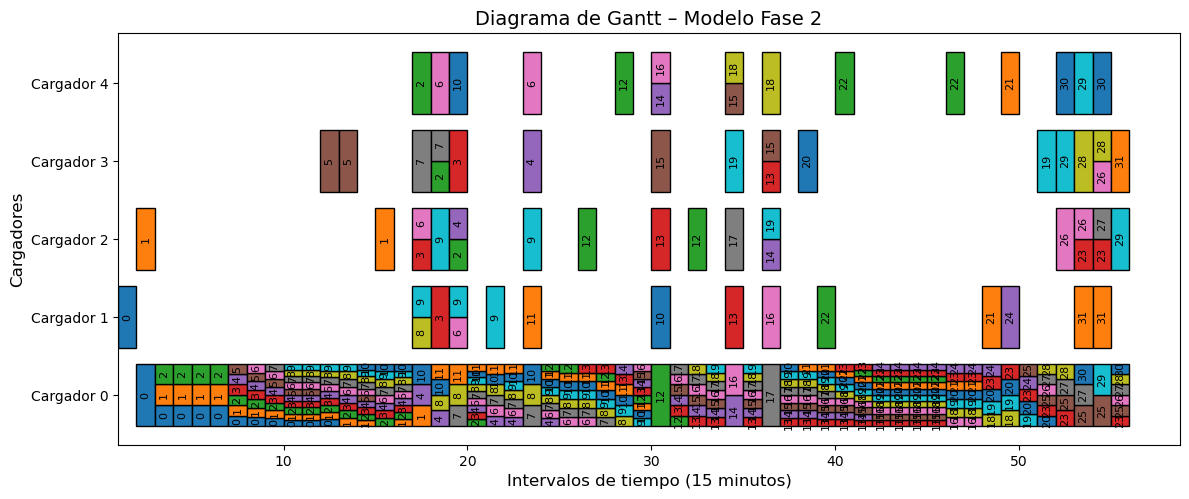

In [75]:
##DIAGRAMA DE GANTT MODELOS
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

def generar_gantt_fase2(x_new, E_new, vehicles, chargers, T):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Crear colores únicos por vehículo
    vehicle_colors = {}
    all_vehicle_ids = [v["id"] for v in vehicles]
    for idx, vehicle_id in enumerate(all_vehicle_ids):
        vehicle_colors[vehicle_id] = f"C{idx % 10}"  # Usar 10 colores base

    # Agrupar asignaciones por (cargador, tiempo)
    grouped_entries = defaultdict(list)
    for t in range(T):
        for j, charger in enumerate(chargers):
            for i, v in enumerate(vehicles):
                if x_new[i, j, t].X > 0.5:
                    grouped_entries[(j, t)].append({
                        "vehicle": v["id"],
                        "energy": E_new[i, j, t].X
                    })

    # Dibujar las barras partidas por cargador y tiempo
    bar_height = 0.8  # Altura total de la barra por cargador
    for (charger, t), assignments in grouped_entries.items():
        n = len(assignments)
        segment_height = bar_height / n

        for k, assignment in enumerate(assignments):
            bottom = charger - bar_height / 2 + k * segment_height

            ax.barh(
                bottom + segment_height / 2,
                width=1,
                left=t,
                height=segment_height,
                color=vehicle_colors[assignment["vehicle"]],
                edgecolor='black'
            )

            # ID del vehículo, en vertical
            ax.text(
                x=t + 0.5, 
                y=bottom + segment_height / 2, 
                s=str(assignment["vehicle"]),
                va='center', ha='center', rotation=90, fontsize=8, color='black'
            )

  

    # Personalización del gráfico
    ax.set_xlabel("Intervalos de tiempo (15 minutos)", fontsize=12)
    ax.set_ylabel("Cargadores", fontsize=12)
    ax.set_title("Diagrama de Gantt – Modelo Fase 2", fontsize=14)
    ax.set_yticks(range(len(chargers)))
    ax.set_yticklabels([f"Cargador {j}" for j in range(len(chargers))])


    # Ajustar diseño
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    plt.show()

# Ejemplo de uso tras optimizar el modelo:
generar_gantt_fase2(x_new, E_new, vehicles, chargers, T)


In [76]:
####### HEURISTICA  #######
import json
import random

# Tiempo de inicio
start_time = time.time()

# Cargar datos
with open(archivo, "r") as file:
    data = json.load(file)

# Procesar vehículos
vehicles = []
for v in data["arrivals"]:
    if "battery_capacity" in v:
        # Calcular required_energy como porcentaje de battery_capacity
        required_energy = v["battery_capacity"] * (v["required_energy"] / 100)
    else:
        # Usar el valor directo de required_energy
        required_energy = float(v["required_energy"])
    
    # Añadir los datos del vehículo a la lista
    vehicles.append({
        "id": v["id"],
        "arrival_time": int(v["arrival_time"] * 4),  # Convertir a intervalos de 15 minutos
        "departure_time": int(v["departure_time"] * 4),
        "required_energy": required_energy,
        "charged_energy": 0.0  # Inicializar energía cargada
    })

# Procesar precios de energía
raw_energy_prices = {int(entry["time"] * 4): float(entry["price"]) for entry in data["energy_prices"]}
energy_prices = {}
last_price = 0.0
for t in range(max(v["departure_time"] for v in vehicles) + 1):
    if t in raw_energy_prices:
        last_price = raw_energy_prices[t]
    energy_prices[t] = last_price

# Procesar cargadores y transformador
chargers = data["parking_config"]["chargers"]
transformer_limit = float(data["parking_config"]["transformer_limit"])

# Inicialización de resultados
schedule = {
    t: {j: {"vehicle": None, "energy": 0.0} for j in range(len(chargers))}
    for t in range(max(v["departure_time"] for v in vehicles))
}

# Función para calcular prioridad con un componente aleatorio
def calculate_priority(vehicle, t):
    remaining_energy = vehicle["required_energy"] - vehicle["charged_energy"]
    remaining_time = vehicle["departure_time"] - t
    max_power = max(c["power"] for c in chargers)
    urgency = remaining_energy / (remaining_time * max_power) if remaining_time > 0 else 0
    noise = random.uniform(0.9, 1.1)  # Aleatoriedad controlada
    return urgency * noise

# Heurística de asignación
total_cost = 0.0
for t in range(max(v["departure_time"] for v in vehicles)):
    available_vehicles = [v for v in vehicles if v["arrival_time"] <= t < v["departure_time"]]
    random.shuffle(available_vehicles)  # Aleatoriedad en el orden inicial
    available_vehicles.sort(key=lambda v: calculate_priority(v, t), reverse=True)

    remaining_transformer_capacity = transformer_limit
    remaining_charger_capacity = {j: chargers[j]["power"] for j in range(len(chargers))}

    for vehicle in available_vehicles:
        remaining_energy = vehicle["required_energy"] - vehicle["charged_energy"]

        # Verificar si el vehículo ya está asignado en t
        already_charged_in_t = any(schedule[t][j]["vehicle"] == vehicle["id"] for j in range(len(chargers)))
        if already_charged_in_t:
            continue

        for charger_id, charger in enumerate(chargers):
            if remaining_transformer_capacity <= 0 or remaining_charger_capacity[charger_id] <= 0:
                continue

            charge = min(remaining_energy, charger["power"], remaining_transformer_capacity, remaining_charger_capacity[charger_id])

            if charge > 0:
                schedule[t][charger_id]["vehicle"] = vehicle["id"]
                schedule[t][charger_id]["energy"] += charge
                vehicle["charged_energy"] += charge
                remaining_transformer_capacity -= charge
                remaining_charger_capacity[charger_id] -= charge
                total_cost += charge * energy_prices[t]
                break  # Ya fue asignado en este t

# Resultados
total_delivered_energy = sum(v["charged_energy"] for v in vehicles)
total_required_energy = sum(v["required_energy"] for v in vehicles)
delivery_percentage = (total_delivered_energy / total_required_energy) * 100

#Tiempo de finalización
end_time = time.time()
execution_time = end_time - start_time


# Imprimir resultados
print("\nPlan de carga por intervalo y cargador:")
for t in range(max(v["departure_time"] for v in vehicles)):
    print(f"\nIntervalo {t}:")
    for charger_id, assignment in schedule[t].items():
        if assignment["vehicle"] is not None and assignment["energy"] > 0:
            print(f"  Cargador {charger_id}:")
            print(f"    Vehículo asignado: {assignment['vehicle']}")
            print(f"    Energía entregada: {assignment['energy']:.2f} kWh")
        else:
            print(f"  Cargador {charger_id}: No asignado")

print("\nEnergía entregada por vehículo:")
for v in vehicles:
    print(f"Vehículo {v['id']}: {v['charged_energy']:.2f} / {v['required_energy']} kWh")

print(f"\nCosto total: ${total_cost:.2f}")
print(f"Porcentaje de entrega total: {delivery_percentage:.2f}%")
print(f"Tiempo de ejecución de la heurística: {execution_time:.4f} segundos")



Plan de carga por intervalo y cargador:

Intervalo 0:
  Cargador 0: No asignado
  Cargador 1: No asignado
  Cargador 2: No asignado
  Cargador 3: No asignado
  Cargador 4: No asignado

Intervalo 1:
  Cargador 0:
    Vehículo asignado: 0
    Energía entregada: 7.00 kWh
  Cargador 1: No asignado
  Cargador 2: No asignado
  Cargador 3: No asignado
  Cargador 4: No asignado

Intervalo 2:
  Cargador 0:
    Vehículo asignado: 0
    Energía entregada: 7.00 kWh
  Cargador 1:
    Vehículo asignado: 1
    Energía entregada: 7.00 kWh
  Cargador 2: No asignado
  Cargador 3: No asignado
  Cargador 4: No asignado

Intervalo 3:
  Cargador 0:
    Vehículo asignado: 0
    Energía entregada: 7.00 kWh
  Cargador 1:
    Vehículo asignado: 2
    Energía entregada: 7.00 kWh
  Cargador 2:
    Vehículo asignado: 1
    Energía entregada: 7.00 kWh
  Cargador 3: No asignado
  Cargador 4: No asignado

Intervalo 4:
  Cargador 0:
    Vehículo asignado: 2
    Energía entregada: 7.00 kWh
  Cargador 1:
    Vehículo a

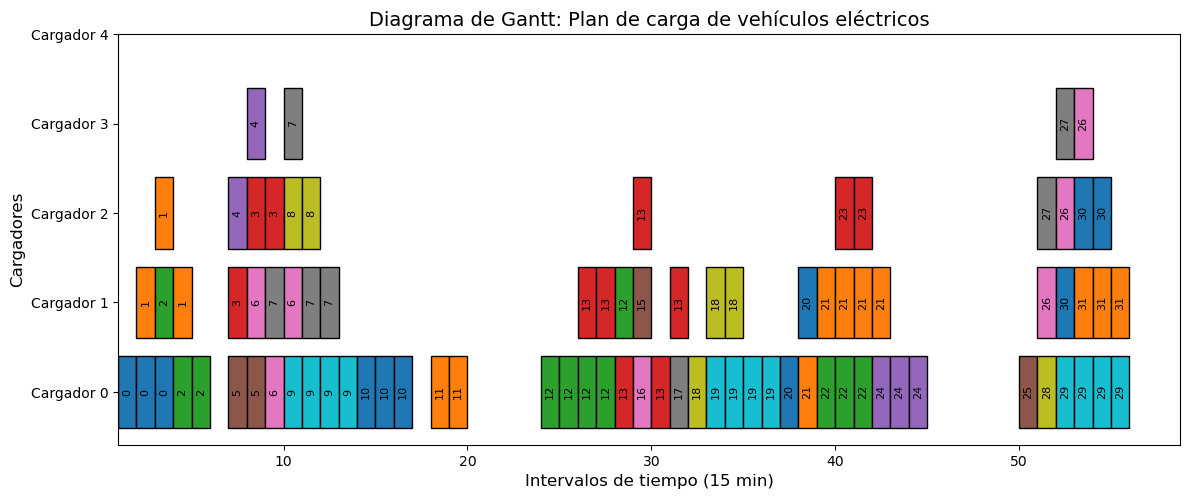

In [77]:
##DIAGRAMA DE GANTT HEURISTICA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

def generar_gantt(schedule, vehicles):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Crear colores únicos por vehículo
    vehicle_colors = {}
    all_vehicle_ids = list({v["id"] for v in vehicles})
    for idx, vehicle_id in enumerate(all_vehicle_ids):
        vehicle_colors[vehicle_id] = f"C{idx % 10}"  # Máximo 10 colores base

    # Agrupar entradas con el mismo cargador, inicio y fin
    grouped_entries = defaultdict(list)
    for t, chargers in schedule.items():
        for charger_id, assignment in chargers.items():
            vehicle_id = assignment["vehicle"]
            energy = assignment["energy"]
            if vehicle_id is not None and energy > 0:
                # Almacenar la entrada para el diagrama de Gantt
                grouped_entries[(charger_id, t)].append(assignment)

    # Dibujar las barras de carga
    bar_height = 0.8  # Altura total de la barra por cargador
    for (charger, t), assignments in grouped_entries.items():
        width = 1  # Tamaño de la barra
        n = len(assignments)
        segment_height = bar_height / n  # Altura de cada franja

        for i, assignment in enumerate(assignments):
            # Calcular la posición inferior de la franja
            bottom = charger - bar_height / 2 + i * segment_height

            # Dibujar la franja
            ax.barh(bottom + segment_height / 2, width=width, left=t,
                    height=segment_height, color=vehicle_colors[assignment["vehicle"]], edgecolor='black')

            # Número del vehículo en vertical
            ax.text(x=t + width / 2, y=bottom + segment_height / 2, s=str(assignment["vehicle"]),
                    va='center', ha='center', color='black', rotation=90, fontsize=8)


    # Personalización del gráfico
    ax.set_xlabel("Intervalos de tiempo (15 min)", fontsize=12)
    ax.set_ylabel("Cargadores", fontsize=12)
    ax.set_title("Diagrama de Gantt: Plan de carga de vehículos eléctricos", fontsize=14)
    ax.set_yticks(range(len(schedule[0])))
    ax.set_yticklabels([f"Cargador {j}" for j in range(len(schedule[0]))])

    # Ajustar espacio para la leyenda
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    plt.show()

# Llamar después de la heurística (aquí usas `schedule` y `vehicles` como ejemplos)
generar_gantt(schedule, vehicles)



In [78]:

##BUSQUEDA LOCAL

import copy

#tiempo de inicio
start_time = time.time()

# Copiamos el plan original para modificarlo localmente
best_schedule = copy.deepcopy(schedule)
best_total_cost = total_cost
best_vehicle_states = copy.deepcopy(vehicles)

improvement = True

while improvement:
    improvement = False

    # Iteramos por vehículo
    for vehicle in best_vehicle_states:
        vid = vehicle["id"]
        arrival = vehicle["arrival_time"]
        departure = vehicle["departure_time"]

        # Buscar los intervalos donde el vehículo fue cargado
        charging_intervals = []
        for t in range(arrival, departure):
            for charger_id, assignment in best_schedule[t].items():
                if assignment["vehicle"] == vid and assignment["energy"] > 0:
                    charging_intervals.append((t, charger_id, assignment["energy"]))

        # Ordenar los intervalos por precio de energía (de más caro a más barato)
        charging_intervals.sort(key=lambda x: energy_prices[x[0]], reverse=True)

        for t_old, charger_id_old, energy_old in charging_intervals:
            for t_new in range(arrival, departure):
                if energy_prices[t_new] >= energy_prices[t_old]:
                    continue  # Solo mover a intervalos más baratos

                # Revisar si ya está en algún cargador en t_new
                ya_asignado = any(
                    best_schedule[t_new][j]["vehicle"] == vid
                    for j in range(len(chargers))
                )
                if ya_asignado:
                    continue  # No se puede estar en más de un cargador a la vez

                # Intentar mover esta energía a un cargador disponible en t_new
                for charger_id_new in range(len(chargers)):
                    current_vehicle = best_schedule[t_new][charger_id_new]["vehicle"]
                    current_energy = best_schedule[t_new][charger_id_new]["energy"]

                    if current_vehicle is not None and current_vehicle != vid:
                        continue

                    charger_power = chargers[charger_id_new]["power"]
                    available_charger = charger_power - current_energy

                    total_energy_tnew = sum(best_schedule[t_new][j]["energy"] for j in range(len(chargers)))
                    available_transformer = transformer_limit - total_energy_tnew

                    energy_to_move = min(energy_old, available_charger, available_transformer)

                    if energy_to_move <= 0:
                        continue

                    # Evaluar mejora
                    new_cost = best_total_cost
                    new_cost -= energy_old * energy_prices[t_old]
                    new_cost += energy_to_move * energy_prices[t_new]

                    if new_cost < best_total_cost:
                        # Quitar carga anterior
                        best_schedule[t_old][charger_id_old]["vehicle"] = None
                        best_schedule[t_old][charger_id_old]["energy"] = 0.0

                        # Poner carga nueva
                        best_schedule[t_new][charger_id_new]["vehicle"] = vid
                        best_schedule[t_new][charger_id_new]["energy"] += energy_to_move

                        # Actualizar carga del vehículo
                        vehicle["charged_energy"] -= energy_old
                        vehicle["charged_energy"] += energy_to_move

                        best_total_cost = new_cost
                        improvement = True
                        break
                if improvement:
                    break
            if improvement:
                break
        if improvement:
            break

#tiempo de finalización
end_time = time.time()
execution_time = end_time - start_time

#Uso transformador
uso_transformador_bl = []
for t in range(T):
    energia_t = sum(entry["energy"] for entry in schedule_bl if entry["time"] == t)
    uso_transformador_bl.append(energia_t)


# Mostrar resultados
print("\n### Plan de carga final por intervalo y cargador (después de mejora local):")
for t in sorted(best_schedule.keys()):
    print(f"Intervalo {t}:")
    for charger_id in sorted(best_schedule[t].keys()):
        assignment = best_schedule[t][charger_id]
        if assignment["energy"] > 0:
            print(f"  Cargador {charger_id}: Vehículo {assignment['vehicle']} | Energía: {assignment['energy']:.2f} kWh")



print("\nEnergía final entregada por vehículo:")
total_required = 0
total_delivered = 0
for v in best_vehicle_states:
    print(f"Vehículo {v['id']}: {v['charged_energy']:.2f} / {v['required_energy']} kWh")
    total_required += v['required_energy']
    total_delivered += v['charged_energy']

percentage_delivered = (total_delivered / total_required) * 100 if total_required > 0 else 0

print(f"\nCosto total después de mejora local: ${best_total_cost:.2f}")
print(f"\nPorcentaje total de energía entregada: {percentage_delivered:.2f}%")
print(f"Tiempo de ejecución de la heurística + búsqueda local: {execution_time:.4f} segundos")






### Plan de carga final por intervalo y cargador (después de mejora local):
Intervalo 0:
Intervalo 1:
  Cargador 0: Vehículo 0 | Energía: 7.00 kWh
Intervalo 2:
  Cargador 0: Vehículo 0 | Energía: 7.00 kWh
  Cargador 1: Vehículo 1 | Energía: 7.00 kWh
Intervalo 3:
  Cargador 0: Vehículo 0 | Energía: 7.00 kWh
Intervalo 4:
Intervalo 5:
Intervalo 6:
Intervalo 7:
Intervalo 8:
Intervalo 9:
Intervalo 10:
Intervalo 11:
Intervalo 12:
Intervalo 13:
  Cargador 1: Vehículo 5 | Energía: 7.00 kWh
Intervalo 14:
  Cargador 1: Vehículo 5 | Energía: 7.00 kWh
Intervalo 15:
  Cargador 1: Vehículo 1 | Energía: 0.87 kWh
Intervalo 16:
Intervalo 17:
  Cargador 0: Vehículo 1 | Energía: 7.00 kWh
  Cargador 1: Vehículo 2 | Energía: 2.00 kWh
  Cargador 2: Vehículo 3 | Energía: 7.00 kWh
  Cargador 3: Vehículo 7 | Energía: 7.00 kWh
  Cargador 4: Vehículo 8 | Energía: 7.00 kWh
Intervalo 18:
  Cargador 0: Vehículo 11 | Energía: 7.00 kWh
  Cargador 1: Vehículo 2 | Energía: 7.00 kWh
  Cargador 2: Vehículo 3 | Energía: 

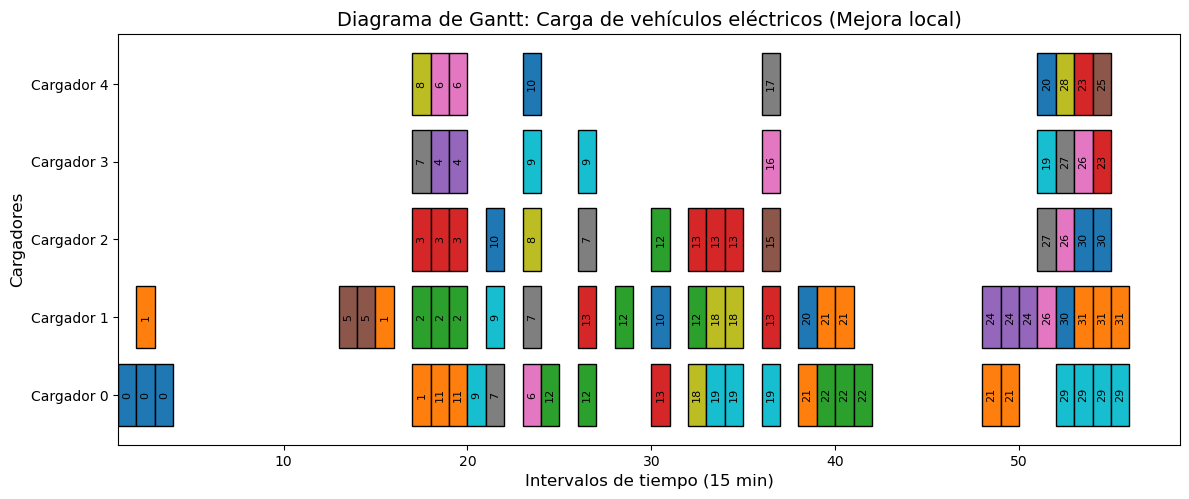

In [79]:
##DIAGRAMA HEURISTICA + BUSQUEDA LOCAL
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

def generar_gantt(schedule, vehicles):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Colores únicos para los vehículos
    vehicle_colors = {}
    all_vehicle_ids = [v["id"] for v in vehicles]
    for idx, vehicle_id in enumerate(all_vehicle_ids):
        vehicle_colors[vehicle_id] = f"C{idx % 10}"  # Usa colores predeterminados de Matplotlib

    # Agrupar entradas con el mismo cargador, intervalo de inicio y fin
    grouped_entries = defaultdict(list)
    for t in sorted(schedule.keys()):
        for charger_id, assignment in schedule[t].items():
            if assignment["vehicle"] is not None and assignment["energy"] > 0:
                # Agrupar los vehículos asignados al mismo cargador en el mismo intervalo
                grouped_entries[(charger_id, t)].append(assignment)

    # Dibujar las barras de carga
    bar_height = 0.8  # Altura total de la barra por cargador
    for (charger, t), assignments in grouped_entries.items():
        width = 1  # Tamaño de la barra
        n = len(assignments)
        segment_height = bar_height / n  # Altura de cada franja

        for i, assignment in enumerate(assignments):
            # Calcular la posición inferior de la franja
            bottom = charger - bar_height / 2 + i * segment_height

            # Dibujar la franja
            ax.barh(bottom + segment_height / 2, width=width, left=t,
                    height=segment_height, color=vehicle_colors[assignment["vehicle"]], edgecolor='black')

            # Número del vehículo en vertical
            ax.text(x=t + width / 2, y=bottom + segment_height / 2, s=str(assignment["vehicle"]),
                    va='center', ha='center', color='black', rotation=90, fontsize=8)


    # Personalización del gráfico
    ax.set_xlabel("Intervalos de tiempo (15 min)", fontsize=12)
    ax.set_ylabel("Cargadores", fontsize=12)
    ax.set_title("Diagrama de Gantt: Carga de vehículos eléctricos (Mejora local)", fontsize=14)
    ax.set_yticks(range(len(next(iter(schedule.values())))))  # Número de cargadores
    ax.set_yticklabels([f"Cargador {j}" for j in range(len(next(iter(schedule.values()))))])

    # Ajustar espacio para la leyenda
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    plt.show()

# Llamar a la función con los datos mejorados (schedule y vehicles como ejemplos)
generar_gantt(best_schedule, best_vehicle_states)


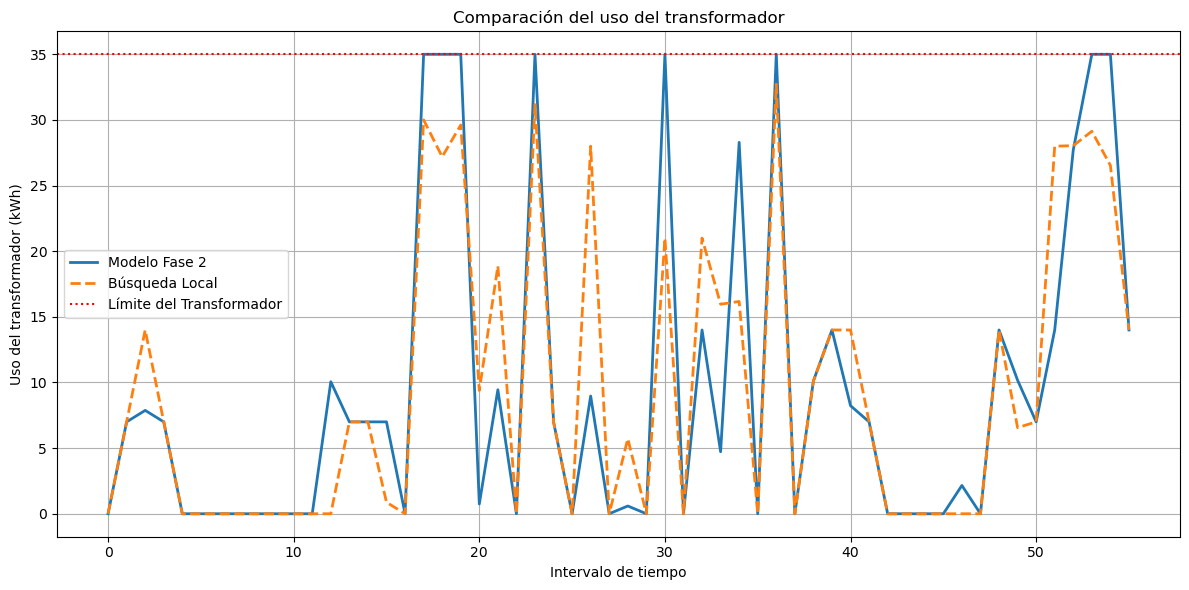

In [80]:
##USO TRANSFORMADOR MODELO VS HEURISTICA+BUSQUEDA LOCAL
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(T), uso_transformador_fase2, label='Modelo Fase 2', linewidth=2)
plt.plot(range(T), uso_transformador_bl, label='Búsqueda Local', linewidth=2, linestyle='--')
plt.axhline(y=transformer_limit, color='red', linestyle=':', label='Límite del Transformador')

plt.xlabel('Intervalo de tiempo')
plt.ylabel('Uso del transformador (kWh)')
plt.title('Comparación del uso del transformador')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
